# Model Performance

In [24]:
# load libraries
from dotenv import load_dotenv 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
import os

# set env vars
load_dotenv()
PUBLIC_ID = os.getenv('PUBLIC_ID')
SECRET_KEY = os.getenv('SECRET_KEY')

# set plot params
plt.rcParams["figure.figsize"] = (14, 5)
plt.style.use("bmh")

In [25]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [36]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(data, score, by):
    df = pd.pivot_table(
        data=data.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [37]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

20.788020133972168

In [38]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'])

---
# Model Ranks

In [39]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.head()

,corrRank,corrRep,date,fncRank,fncRep,fncV3Rank,fncV3Rep,mmcRank,mmcRep,tcRank,tcRep,modelName
0,1895,0.021030,2023-02-16 00:00:00+00:00,2292,0.015754,4266.0,0.006897,NaN,NaN,7757.0,-0.007132,dh_foxhound
1,1772,0.021406,2023-02-15 00:00:00+00:00,2203,0.016283,4145.0,0.007128,NaN,NaN,7928.0,-0.007793,dh_foxhound
2,2093,0.018699,2023-02-14 00:00:00+00:00,2499,0.014490,4861.0,0.005163,NaN,NaN,7803.0,-0.007221,dh_foxhound
3,2303,0.017617,2023-02-11 00:00:00+00:00,2690,0.013261,5723.0,0.003682,NaN,NaN,8014.0,-0.008420,dh_foxhound
4,2615,0.015387,2023-02-10 00:00:00+00:00,2885,0.010854,6515.0,0.001390,NaN,NaN,7678.0,-0.006498,dh_foxhound


In [40]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira'],
      dtype=object)

In [41]:
# model lists
lgbm_models = ['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls']
dnn_models = ['dh_dojo', 'dh_gaia', 'dh_terra', 'dh_spira']

In [42]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

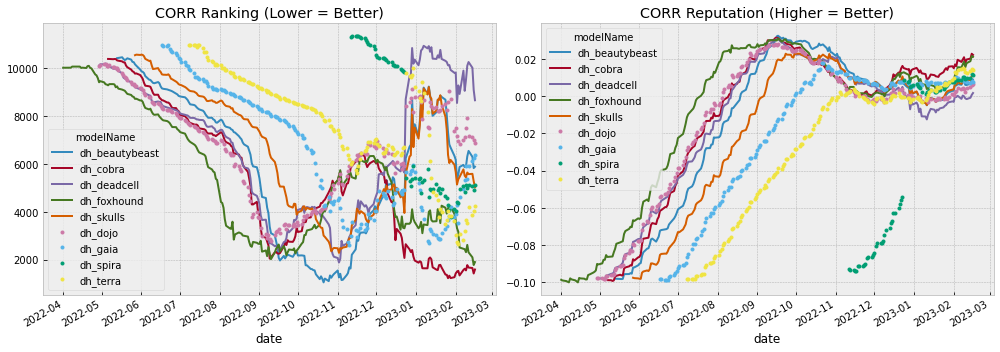

In [43]:
# plot  corr rank and rep
corrdf_lgbm = rank.loc[(rank["date"]>=AFTER_DATE) & (rank["modelName"].isin(lgbm_models))]
corrdf_dnn = rank.loc[(rank["date"]>=AFTER_DATE) & (rank["modelName"].isin(dnn_models))]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='.')
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='.')
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

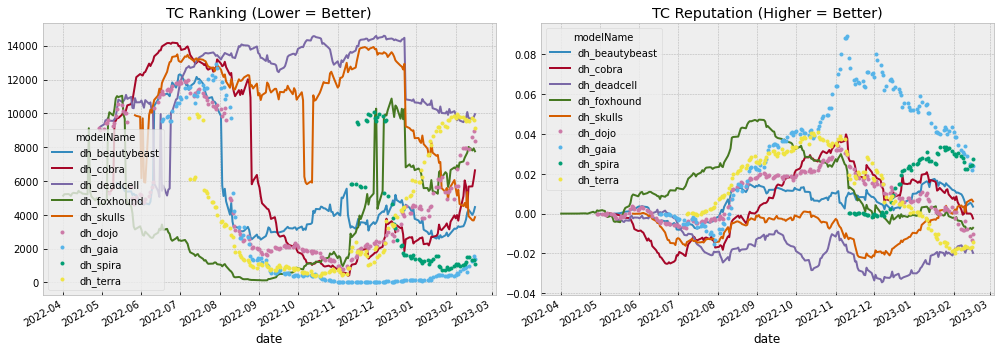

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0], style='.')
axes[0].set_title("TC Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf_lgbm[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='-')
pd.pivot_table(
    data=corrdf_dnn[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1], style='.')
axes[1].set_title("TC Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/TCRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [52]:
# function to plot
def plot_model_performance(perf_agg_list, score_name, save_path):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for df in perf_agg_list:
        df.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0], style='-')
    for df in perf_agg_list:
        df.loc[AFTER_DATE:].cumsum().plot(ax=axes[1], style='-')      
    axes[0].set_title(f"Rolling 7-Day {score_name}")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel(f"{score_name}")
    axes[1].set_title(f"Cumulative {score_name}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel(f"{score_name}")
    plt.tight_layout()
    plt.savefig(f'{save_path}', facecolor='w')
    plt.show()

In [53]:
# get round performance
perf_lgbm = get_model_performance(model_list=lgbm_models)
perf_dnn = get_model_performance(model_list=dnn_models)
perf_all = get_model_performance(model_list=model_list)

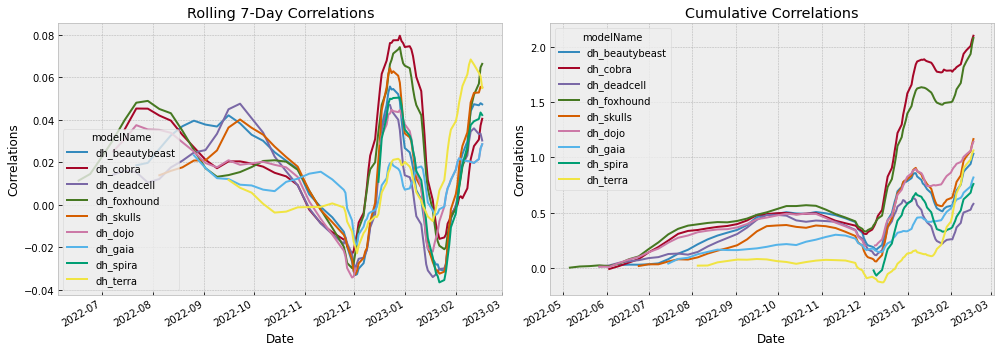

In [55]:
# get mean corr by round
lgbm_avg_corr_by_date = get_model_performance_aggregated(
    data=perf_lgbm, 
    score="corr", 
    by="roundResolveTime"
)

dnn_avg_corr_by_date = get_model_performance_aggregated(
    data=perf_dnn, 
    score="corr", 
    by="roundResolveTime"
)

plot_model_performance(
    perf_agg_list=[lgbm_avg_corr_by_date, dnn_avg_corr_by_date], 
    score_name='Correlations', 
    save_path='plots/ModelCorrPlots.png'
)

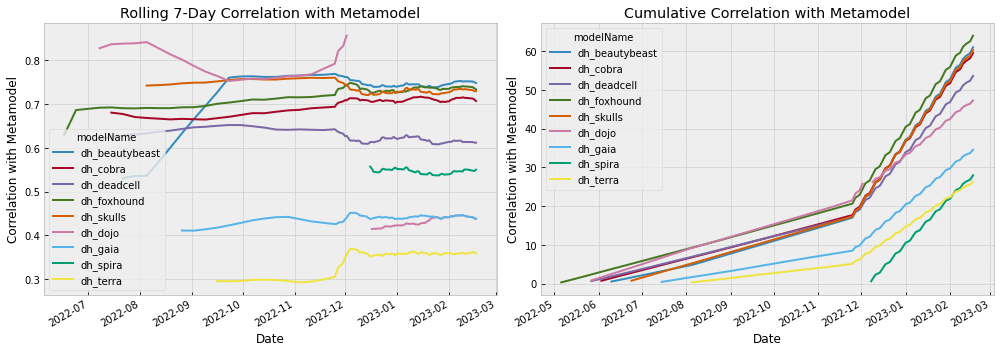

In [58]:
# get mean cwmm by round
lgbm_avg_cwmm_by_date = get_model_performance_aggregated(
    data=perf_lgbm, 
    score="corrWMetamodel", 
    by="roundResolveTime"
)

dnn_avg_cwmm_by_date = get_model_performance_aggregated(
    data=perf_dnn, 
    score="corrWMetamodel", 
    by="roundResolveTime"
)

plot_model_performance(
    perf_agg_list=[lgbm_avg_cwmm_by_date, dnn_avg_cwmm_by_date], 
    score_name='Correlation with Metamodel', 
    save_path='plots/ModelCWMMPlots.png'
)

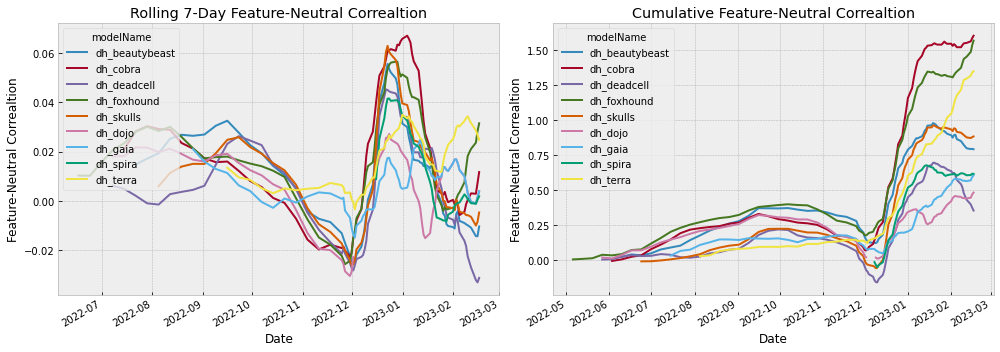

In [61]:
# get mean fnc by round
lgbm_avg_fnc_by_date = get_model_performance_aggregated(
    data=perf_lgbm, 
    score="fnc", 
    by="roundResolveTime"
)

dnn_avg_fnc_by_date = get_model_performance_aggregated(
    data=perf_dnn, 
    score="fnc", 
    by="roundResolveTime"
)

plot_model_performance(
    perf_agg_list=[lgbm_avg_fnc_by_date, dnn_avg_fnc_by_date], 
    score_name='Feature-Neutral Correaltion', 
    save_path='plots/ModelFNCPlots.png'
)

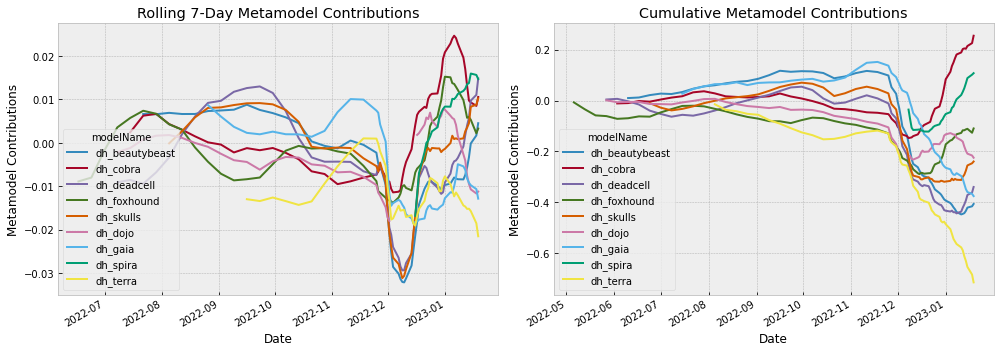

In [62]:
# get mean mmc by round
lgbm_avg_mmc_by_date = get_model_performance_aggregated(
    data=perf_lgbm, 
    score="mmc", 
    by="roundResolveTime"
)

dnn_avg_mmc_by_date = get_model_performance_aggregated(
    data=perf_dnn, 
    score="mmc", 
    by="roundResolveTime"
)

plot_model_performance(
    perf_agg_list=[lgbm_avg_mmc_by_date, dnn_avg_mmc_by_date], 
    score_name='Metamodel Contributions', 
    save_path='plots/ModelMMCPlots.png'
)

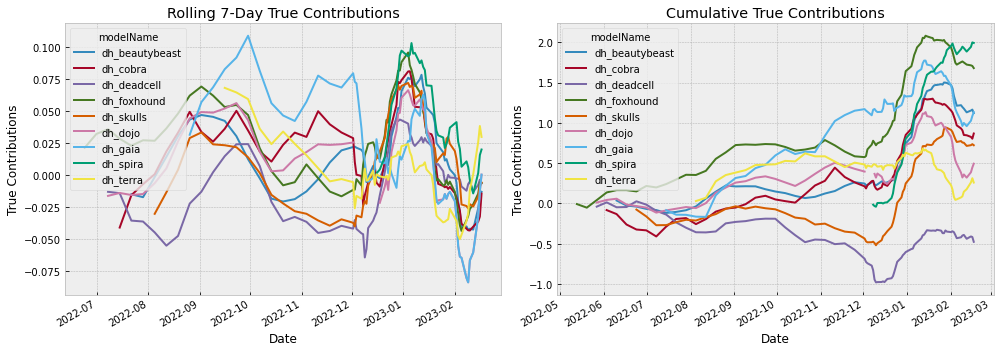

In [63]:
# get mean mmc by round
lgbm_avg_tc_by_date = get_model_performance_aggregated(
    data=perf_lgbm,
    score="tc", 
    by="roundResolveTime"
)

dnn_avg_tc_by_date = get_model_performance_aggregated(
    data=perf_dnn,
    score="tc", 
    by="roundResolveTime"
)

plot_model_performance(
    perf_agg_list=[lgbm_avg_tc_by_date, dnn_avg_tc_by_date], 
    score_name='True Contributions', 
    save_path='plots/ModelTCPlots.png'
)

---
# Model Payouts & Staking

In [64]:
# get payout
payout_lgbm = get_model_value(lgbm_models, "payout")
payout_dnn = get_model_value(dnn_models, "payout")
payout_all = get_model_value(model_list, "payout")

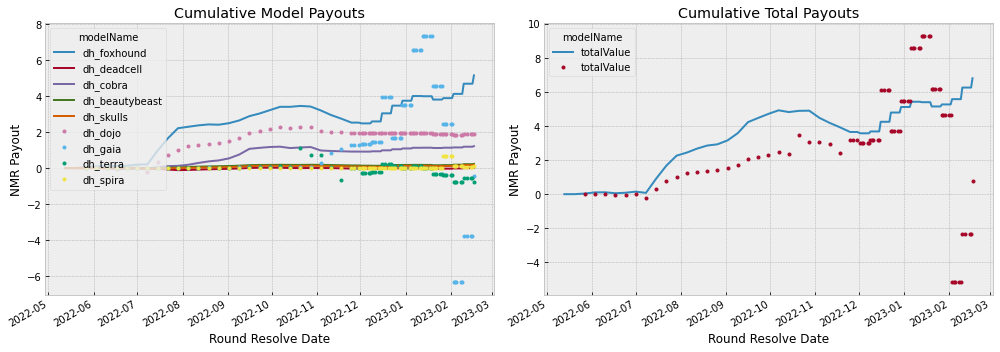

In [65]:
# plot payouts
try:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    payout_lgbm.loc[AFTER_DATE:][lgbm_models].cumsum().plot(ax=axes[0], style='-')
    payout_dnn.loc[AFTER_DATE:][dnn_models].cumsum().plot(ax=axes[0], style='.')
    payout_lgbm.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1], style='-')
    payout_dnn.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1], style='.')
    axes[0].set_title("Cumulative Model Payouts")
    axes[0].set_xlabel("Round Resolve Date")
    axes[0].set_ylabel("NMR Payout")
    axes[1].set_title("Cumulative Total Payouts")
    axes[1].set_xlabel("Round Resolve Date")
    axes[1].set_ylabel("NMR Payout")
    plt.tight_layout()
    plt.savefig('plots/PayoutPlots.png', facecolor='w')
    plt.show()
except:
    pass

In [66]:
# get payout
staking_lgbm = get_model_value(lgbm_models, "staking")
staking_dnn = get_model_value(dnn_models, "staking")
staking_all = get_model_value(model_list, "staking")

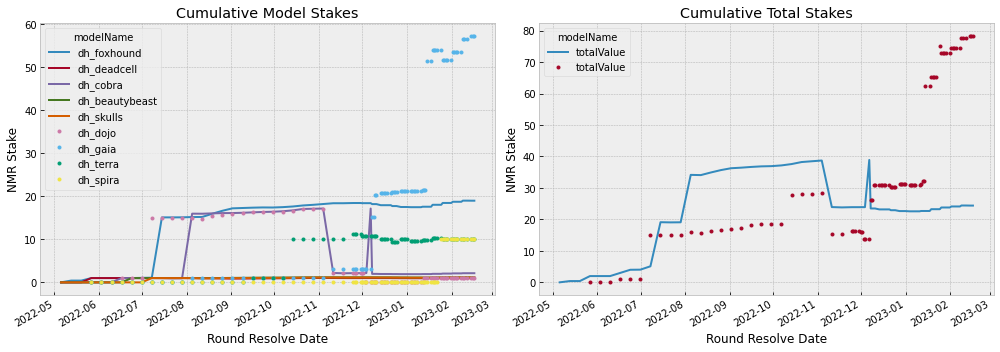

In [67]:
# plot payouts
try:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    staking_lgbm.loc[AFTER_DATE:][lgbm_models].plot(ax=axes[0], style='-')
    staking_dnn.loc[AFTER_DATE:][dnn_models].plot(ax=axes[0], style='.')
    staking_lgbm.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1], style='-')
    staking_dnn.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1], style='.')
    axes[0].set_title("Cumulative Model Stakes")
    axes[0].set_xlabel("Round Resolve Date")
    axes[0].set_ylabel("NMR Stake")
    axes[1].set_title("Cumulative Total Stakes")
    axes[1].set_xlabel("Round Resolve Date")
    axes[1].set_ylabel("NMR Stake")
    plt.tight_layout()
    plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
    plt.show()
except:
    pass

---
# Total Return

In [68]:
# daily staking 
round_return = pd.concat([payout_all["totalValue"], staking_all["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

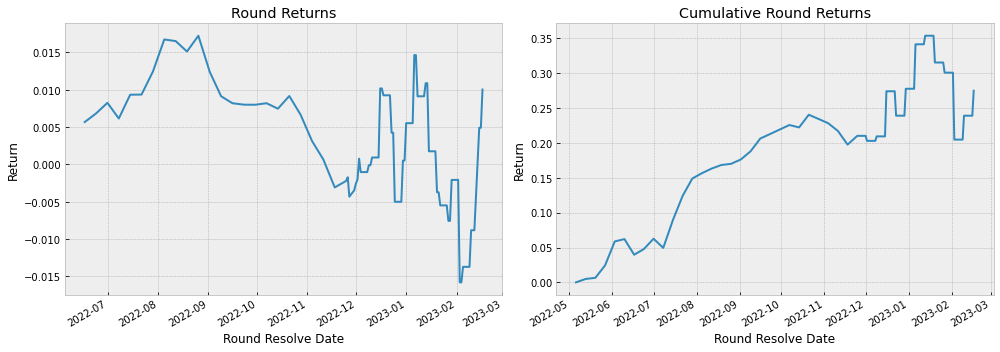

In [69]:
# plot round return
fig, axes = plt.subplots(nrows=1, ncols=2)
round_return["return"].rolling(7).mean().plot(ax=axes[0])
round_return["return"].cumsum().plot(ax=axes[1])
axes[0].set_title("Round Returns")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("Return")
axes[1].set_title("Cumulative Round Returns")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("Return")
plt.tight_layout()
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()

---
# Sharpe Performance

In [71]:
# sharpe calc
def get_sharpe(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["modelName"])[metric].size(),
        df_clean.groupby(["modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = sharpe_df.loc[sharpe_df["n"]>=10].sort_values("sharpe")
    return sharpe_df

In [72]:
# rank by sharpe
corr_sharpe_df = get_sharpe(df=perf_all, metric='corr')
tc_sharpe_df = get_sharpe(df=perf_all, metric='tc')

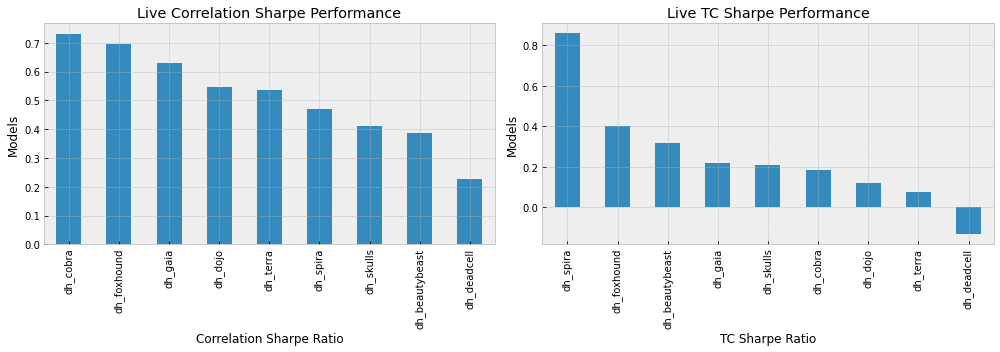

In [73]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[0])
tc_sharpe_df["sharpe"].sort_values(ascending=False).plot.bar(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance")
axes[0].set_xlabel("Correlation Sharpe Ratio")
axes[0].set_ylabel("Models")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("TC Sharpe Ratio")
axes[1].set_ylabel("Models")
plt.tight_layout()
plt.savefig('plots/SharpeRatioPlots.png', facecolor='w')
plt.show();